# Transfer learning

The goal of the exercise is to investigate data augmentation and transfer learning on a very small dataset (2000 training images).

The code is based on the keras tutorial:

<https://keras.io/guides/transfer_learning/#an-endtoend-example-finetuning-an-image-classification-model-on-a-cats-vs-dogs>

The data is provided as part of a Google tutorial:

<https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part1.ipynb>

In [21]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()

import tensorflow as tf

2.17.1


## Loading the cats and dogs data

The data we will use is a subset of the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) dataset available on Kaggle, which contains 25,000 images. Here, we use only 1000 dogs and 1000 cats to decrease training time and make the problem harder.

The following cell downloads the data and decompresses it in `/tmp/` (it will be erased at the next restart of your computer).

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2025-01-10 13:46:26--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.207, 74.125.128.207, 74.125.143.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  27.1MB/s    in 2.4s    

2025-01-10 13:46:29 (27.1 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



All we have is a bunch of `*.jpg` images organized in a training and validation set, separated by their binary class dog vs. cat:

```
cats_and_dogs_filtered/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
```

Feel free to download the data on your computer and have a look at the images directly.

The next cell checks the structure of the image directory:


In [3]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = base_dir + '/train'
validation_dir = base_dir + '/validation'

print('total training cat images:', len(os.listdir(train_dir + '/cats')))
print('total training dog images:', len(os.listdir(train_dir + '/dogs')))
print('total validation cat images:', len(os.listdir(validation_dir + '/cats')))
print('total validation dog images:', len(os.listdir(validation_dir + '/dogs')))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


The next cell visualizes some cats and dogs from the training set.

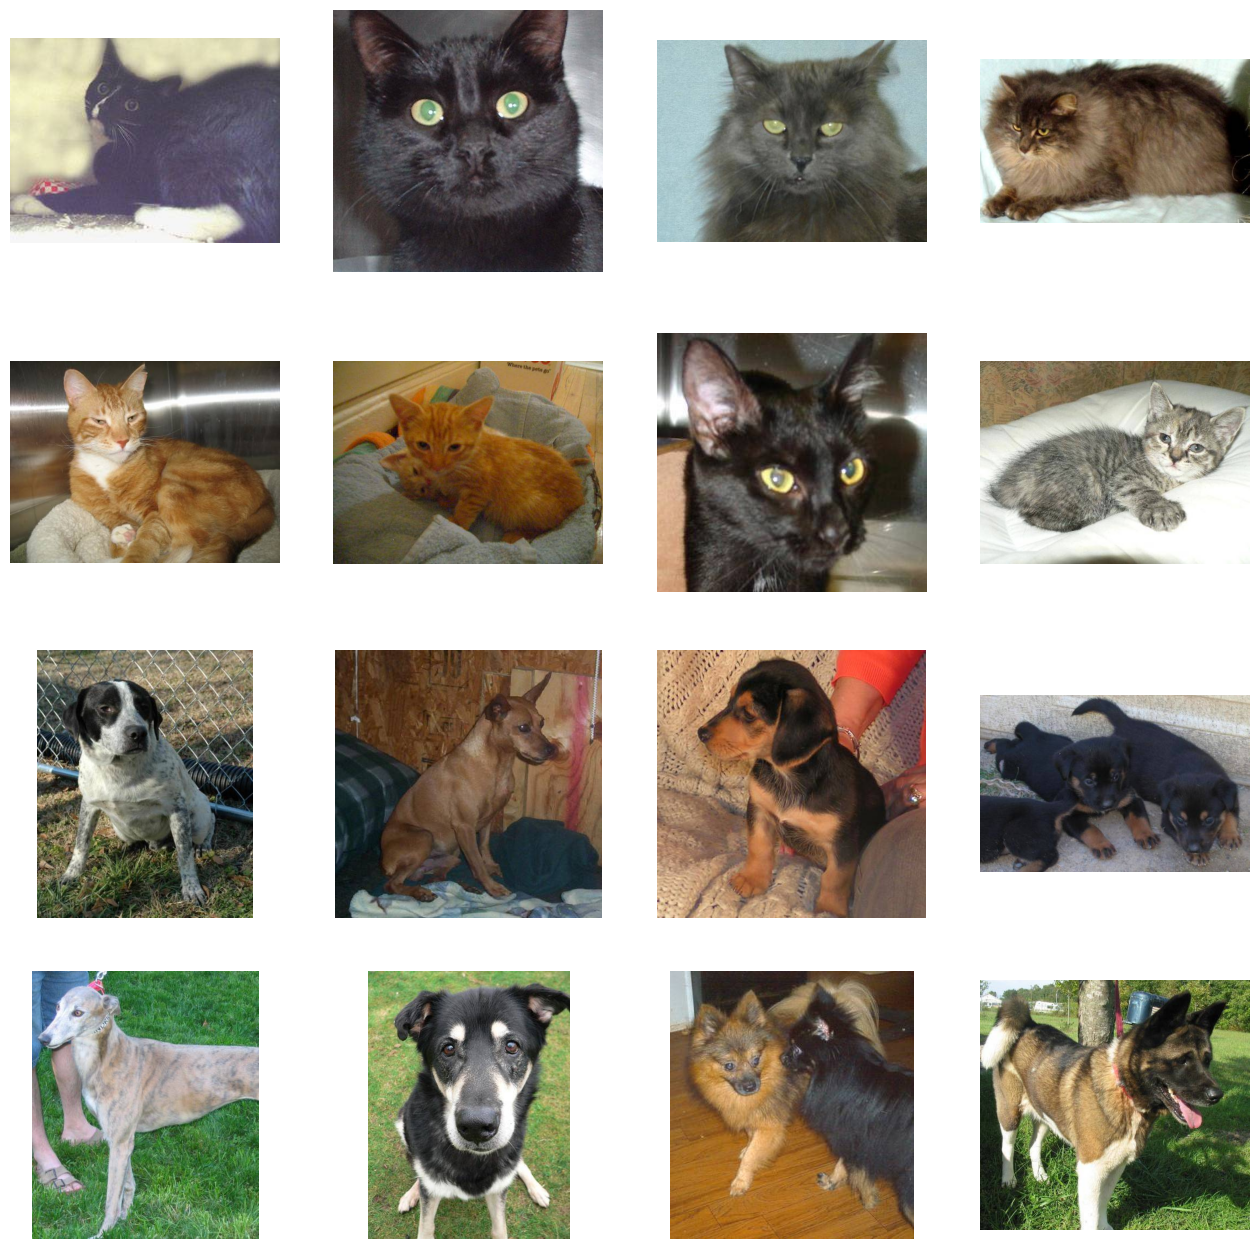

In [4]:
import matplotlib.image as mpimg

fig = plt.figure(figsize=(16, 16))

idx = rng.choice(1000-8, 1)[0]

next_cat_pix = [os.path.join(train_dir + '/cats', fname) for fname in os.listdir(train_dir + '/cats')[idx:idx+8]]
next_dog_pix = [os.path.join(train_dir + '/dogs', fname) for fname in os.listdir(train_dir + '/dogs')[idx:idx+8]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  ax = plt.subplot(4, 4, i + 1)
  ax.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In order to train a binary classifier on this data, we would need to load the images and transform them into Numpy arrays, or a `tf.data.Dataset` object, that can be passed to tensorflow. Fortunately, keras provides an utility to do it automatically: `image_dataset_from_directory`. Doc:

<https://keras.io/api/data_loading/image/>

<https://www.tensorflow.org/api_docs/python/tf/data/Dataset>

The procedure is to create a `tf.data.Dataset` instance and to create an **iterator** that will return minibatches on demand when training the neural network. The main advantage of this approach is that you do not need to load the whole dataset in the RAM (not possible for most realistic datasets), but adds an overhead between each minibatch.

```python
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,                  # This is the source directory for training images
    labels='inferred',          # Infers the lables automatically from the folder structure
    label_mode='binary',        # Since we use binary_crossentropy loss, we need binary labels
    batch_size=64,
    image_size=(height, width),
    shuffle=True
)
```

**Q:** Create two datasets `train_ds` and `validation_ds` for the training and validation sets respectively, with a batch size of 64.


In [40]:
batch_size = 64
img_height = 150
img_width = 150

In [45]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


We have to rescale it to a meaningful range, such as [0, 1] or [-1, 1]. We can use special network layers for this purpuse and stack these using `tf.keras.Sequential`.

The `Rescaling` layer makes sure that the pixels will be represented by float values between -1 and 1, not integers between 0 and 255. Unfortunately, it is not possible (or very hard) to perform mean-removal using this method.
You have to either integrate these layers into your model after the input layer or to apply them seperately on all your data (all means each example the network recives has to be rescaled and resized similarly).

``` python
preprocessed_data = dataset.map(lambda x, y: (preprocessing_pipeline(x), y), num_parallel_calls=tf.data.AUTOTUNE)
```
**Q:** Define a, so called, preprocessing pipeline for rescaling the input layers and preprocess the dataset by applying it on each entry using `map`.

In [44]:
# define operations of the preprocessing pipeline, multiple operations could be stacked
preprocessing_pipeline = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)
])

In [46]:
# apply rescaling as preprocessing on both datasets
train_ds = train_ds.map(lambda x, y: (preprocessing_pipeline(x), y), num_parallel_calls=tf.data.AUTOTUNE)

validation_ds = validation_ds.map(lambda x, y: (preprocessing_pipeline(x), y), num_parallel_calls=tf.data.AUTOTUNE)

**Q:** Sample a minibatch from the training dataset by calling `take(1).get_single_element()` and display an image. Call the cell multiple times.

Hint: `take(1)` will output the first minibatch as dataset object over which can be iterated. Each entry is comprised by images its labels.

(64, 150, 150, 3)


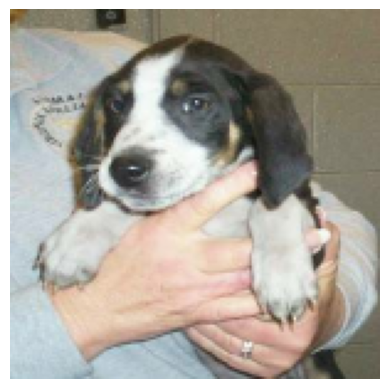

In [47]:
# retrieve the minibatch
X, t = train_ds.take(1).get_single_element()

print(X.shape)

plt.figure()
plt.imshow(X[0, :, :, :])
plt.axis("Off")
plt.show()

## Functional API of Keras

In the previous exercises, we used the Sequential API of keras, which stacks layers on top of each other:

```python
model = tf.keras.Sequential()

model.add(tf.keras.layers.Input((28, 28, 1)))

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu')
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(10, activation='softmax'))
```

In this exercise, we will use the Functional API of keras, which gives much more freedom to the programmer. The main difference is that you can explicitly specify from which layer a layer should take its inputs:

```python
inputs = tf.keras.layers.Input((28, 28, 1))

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Flatten()(x)

outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
```

This allows to create complex architectures, for examples with several output layers.

**Q:** Modify your CNN of last exercise so that it is defined with the Functional API and train it on MNIST.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training data: (60000, 28, 28) (60000,)
Test data: (10000, 28, 28) (10000,)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 150)                 │         240,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 260,476 (1017.48 KB)

 Trainable params: 260,476 (1017.48 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6436 - loss: 1.0317 - val_accuracy: 0.9740 - val_loss: 0.0937
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9316 - loss: 0.2240 - val_accuracy: 0.9805 - val_loss: 0.0640
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9466 - loss: 0.1699 - val_accuracy: 0.9838 - val_loss: 0.0522
Epoch 4/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9566 - loss: 0.1404 - val_accuracy: 0.9868 - val_loss: 0.0449
Epoch 5/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9626 - loss: 0.1237 - val_accuracy: 0.9875 - val_loss: 0.0417
Epoch 6/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9665 - loss: 0.1078 - val_accuracy: 0.9867 - val_loss: 0.0423
Epoch 7/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9698 - loss: 0.0998 - val_accuracy: 0.9887 - val_loss: 0.0385
Epoch 8/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9702 - loss: 0.0914 - val_accura

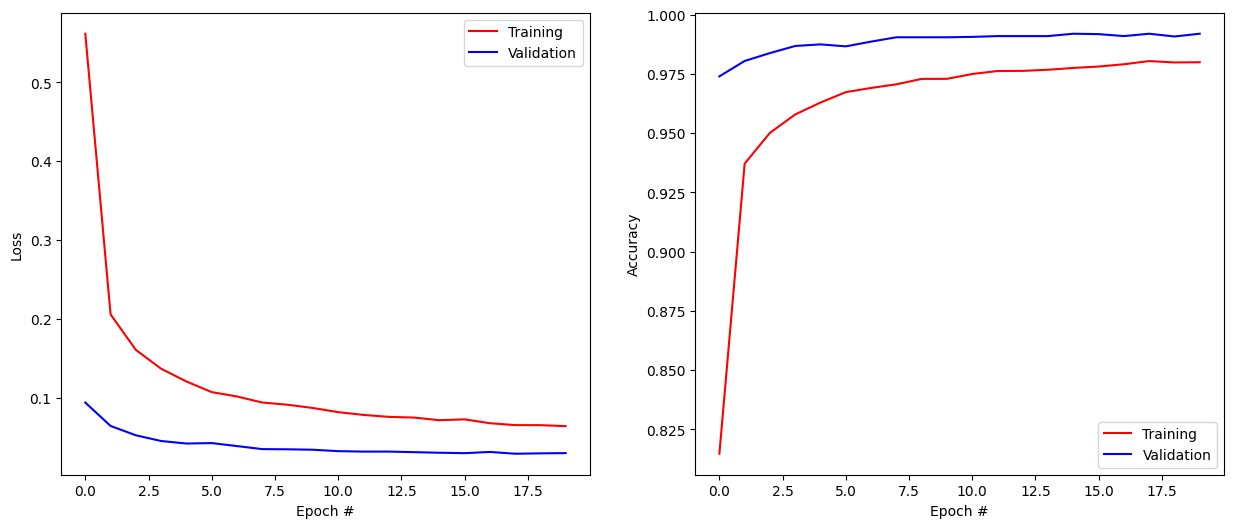

In [8]:
# Fetch the MNIST data
(X_train, t_train), (X_test, t_test) = tf.keras.datasets.mnist.load_data()
print("Training data:", X_train.shape, t_train.shape)
print("Test data:", X_test.shape, t_test.shape)

# Normalize the values
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.

# Mean removal
X_mean = np.mean(X_train, axis=0)
X_train -= X_mean
X_test -= X_mean

# One-hot encoding
T_train = tf.keras.utils.to_categorical(t_train, 10)
T_test = tf.keras.utils.to_categorical(t_test, 10)

# Delete all previous models to free memory
tf.keras.backend.clear_session()

# Functional model
inputs = tf.keras.layers.Input((28, 28, 1))

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='valid')(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(150, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# Learning rule
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

# Loss function
model.compile(
    loss='categorical_crossentropy', # loss
    optimizer=optimizer, # learning rule
    metrics=['accuracy'] # show accuracy
)

print(model.summary())

history = tf.keras.callbacks.History()

model.fit(
    X_train, T_train,
    batch_size=64,
    epochs=20,
    validation_split=0.1,
    callbacks=[history]
)

score = model.evaluate(X_test, T_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(history.history['loss'], '-r', label="Training")
plt.plot(history.history['val_loss'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], '-r', label="Training")
plt.plot(history.history['val_accuracy'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Training a CNN from scratch

Let's now train a randomly-initialized CNN on the dog vs. cat data. You are free to choose any architecture you like, the only requirements are:

* The input image must be 150x150x3:

```python
tf.keras.layers.Input(shape=(150, 150, 3))
```

* The output neuron must use the logistic/sigmoid activation function (binary classification:

```python
tf.keras.layers.Dense(1, activation='sigmoid')
```

* The loss function must be `'binary_crossentropy'` and the metric `binary_accuracy`:

```python
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['binary_accuracy'])
```

There is not a lot of data, so you can safely go deep with your architecture (i.e. with convolutional layers and max-pooling until the image dimensions are around 7x7), especially if you use the GPU on Colab.

To train and validate the network on the generators, just pass them to `model.fit()`:

```python
model.fit(
      train_ds,
      epochs=20,
      validation_data=validation_ds,
      callbacks=[history])
```

**Q:** Design a CNN and train it on the data for 30 epochs. A final validation accuracy around 72% -  75% is already good, you can then go to the next question.

In [30]:
def random_model(augmentation_layers=None):
    # Delete all previous models to free memory
    tf.keras.backend.clear_session()

    # Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
    # the three color channels: R, G, and B
    inputs = tf.keras.layers.Input(shape=(img_height, img_width, 3))

    # Adds augmentation layers on demand
    if augmentation_layers != None:
        inputs = augmentation_layers(inputs)

    # First convolution extracts 16 filters that are 3x3
    # Convolution is followed by max-pooling layer with a 2x2 window
    x = tf.keras.layers.Conv2D(16, 3)(inputs)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Second convolution extracts 32 filters that are 3x3
    # Convolution is followed by max-pooling layer with a 2x2 window
    x = tf.keras.layers.Conv2D(32, 3)(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Third convolution extracts 64 filters that are 3x3
    # Convolution is followed by max-pooling layer with a 2x2 window
    x = tf.keras.layers.Conv2D(64, 3)(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Fourth convolution extracts 64 filters that are 3x3
    # Convolution is followed by max-pooling layer with a 2x2 window
    x = tf.keras.layers.Conv2D(64, 3)(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Flatten feature map to a 1-dim tensor so we can add fully connected layers
    x = tf.keras.layers.Flatten()(x)

    # Create a fully connected layer with ReLU activation and 512 hidden units
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Create output layer with a single node and sigmoid activation
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Create model:
    # input = input feature map
    # output = input feature map + stacked convolution/maxpooling layers + fully
    # connected layer + sigmoid output layer
    model = tf.keras.Model(inputs, outputs)

    # Compile model for binary classification
    model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                metrics=['binary_accuracy'])

    print(model.summary())

    return model

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 148, 148, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 72, 72, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 34, 34, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 1,667,169 (6.36 MB)

 Trainable params: 1,667,169 (6.36 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - binary_accuracy: 0.4938 - loss: 0.7970 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - binary_accuracy: 0.5083 - loss: 0.6928 - val_binary_accuracy: 0.5220 - val_loss: 0.6927
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - binary_accuracy: 0.5260 - loss: 0.6915 - val_binary_accuracy: 0.5560 - val_loss: 0.6919
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - binary_accuracy: 0.5648 - loss: 0.6869 - val_binary_accuracy: 0.5090 - val_loss: 0.6905
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - binary_accuracy: 0.5694 - loss: 0.6782 - val_binary_accuracy: 0.5370 - val_loss: 0.6854
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - binary_accuracy: 0.5833 - loss: 0.6723 - val_binary_accuracy: 0.5220 - val_loss: 0.6880
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - binary_accuracy: 0.6245 - loss: 0.6432 - val_binary_accuracy: 0.6240 - val_loss: 0.6357
E

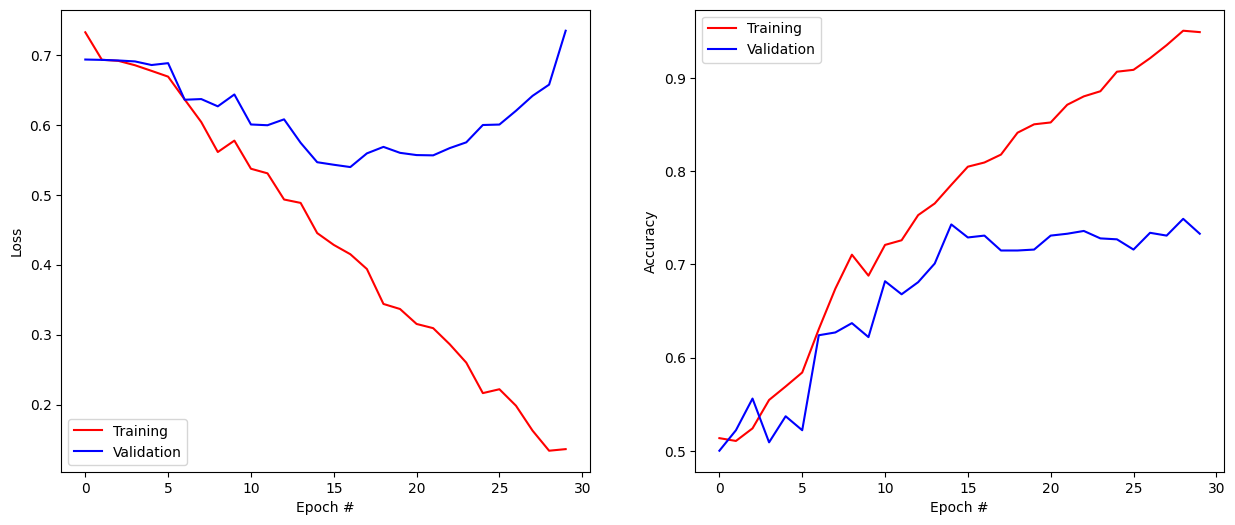

In [31]:
model = random_model()

history = tf.keras.callbacks.History()
model.fit(
      train_ds,
      epochs=30,
      validation_data=validation_ds,
      callbacks=[history])

plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(history.history['loss'], '-r', label="Training")
plt.plot(history.history['val_loss'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['binary_accuracy'], '-r', label="Training")
plt.plot(history.history['val_binary_accuracy'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**A:** There is no unique solution, but it is very difficult to avoid overfitting with such a low amount of data. The validation accuracy saturates between 70% and 75% while the training accuracy reaches 100% if you train for more epochs.

## Data augmentation

The 2000 training images will never be enough to train a CNN from scratch without overfitting, no matter how much regularization you use. A first trick that may help is **data augmentation**, i.e. to artificially create variations of each training image (translation, rotation, scaling, flipping, etc) while preserving the class of the images (a cat stays a cat after rotating the image).

Predefined image augmentation layers allow to automatically apply various transformations.

<https://keras.io/api/layers/preprocessing_layers/image_augmentation/>

```python
augmentation_preprocessing_pipeline = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1, fill_mode="nearest"),
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
    tf.keras.layers.RandomZoom(0.2, fill_mode="nearest")
])
```

Refer the doc for the meaning of the parameters.

To investigate the transformations, let's apply them on a single image, for example the first cat of the training set:

```python
img = tf.keras.preprocessing.image.load_img('/tmp/cats_and_dogs_filtered/train/cats/cat.0.jpg')
img = tf.keras.preprocessing.image.img_to_array(img)  
img = img.reshape((1,) + img.shape)
```

We can pass this image to the pipeline, do not forget the scaling pipeline, and retrieve minibatches of augmented images:

```python
augmented_img = augmentation_preprocessing_pipeline(preprocessing_pipeline(img))
```


**Q:** Implement a preprocessing pipeline for data augmentations.

In [50]:
augmentation_preprocessing_pipeline = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1, fill_mode="nearest"),
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
    tf.keras.layers.RandomZoom(0.2, fill_mode="nearest")
])

**Q:** Display various augmented images. Vary the parameters individually by setting all but one to their default value in order to understand their effect.

In [ ]:
img = tf.keras.preprocessing.image.load_img('/tmp/cats_and_dogs_filtered/train/cats/cat.0.jpg')
img = tf.keras.preprocessing.image.img_to_array(img)
img = img.reshape((1,) + img.shape)

# apply image augmentations
augmented_img = augmentation_preprocessing_pipeline(preprocessing_pipeline(img))

# visualization
plt.figure(figsize=(8, 8))
plt.imshow(img[0, :, :, :]/255.)
plt.axis("Off")
plt.title("Original")
plt.figure(figsize=(8, 8))
plt.imshow(augmented_img[0, :, :, :])
plt.axis("Off")
plt.title("Augmented")
plt.show()

**Q:** Add the augmentation layers after the input layer to your model. They will be only executed during training. Use the parameters defined in the previous question (feel free to experiment, but that can cost time). The validation dataset remains without data augmentations (only rescale and resize). Train the exact same network as before using this augmentions. What happens? You may need to train much longer in order to see the effect.

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_6CLONE (InputLayer)     │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 148, 148, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 72, 72, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 34, 34, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 1,667,169 (6.36 MB)

 Trainable params: 1,667,169 (6.36 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 238ms/step - binary_accuracy: 0.5049 - loss: 0.7140 - val_binary_accuracy: 0.5000 - val_loss: 0.6926
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - binary_accuracy: 0.5055 - loss: 0.6912 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - binary_accuracy: 0.5307 - loss: 0.6909 - val_binary_accuracy: 0.5030 - val_loss: 0.6923
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - binary_accuracy: 0.5593 - loss: 0.6846 - val_binary_accuracy: 0.5000 - val_loss: 0.6950
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - binary_accuracy: 0.5283 - loss: 0.6927 - val_binary_accuracy: 0.5310 - val_loss: 0.6860
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - binary_accuracy: 0.5850 - loss: 0.6699 - val_binary_accuracy: 0.5380 - val_loss: 0.6797
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - binary_accuracy: 0.6375 - loss: 0.6443 - val_binary_accuracy: 0.5590 - val_loss: 0

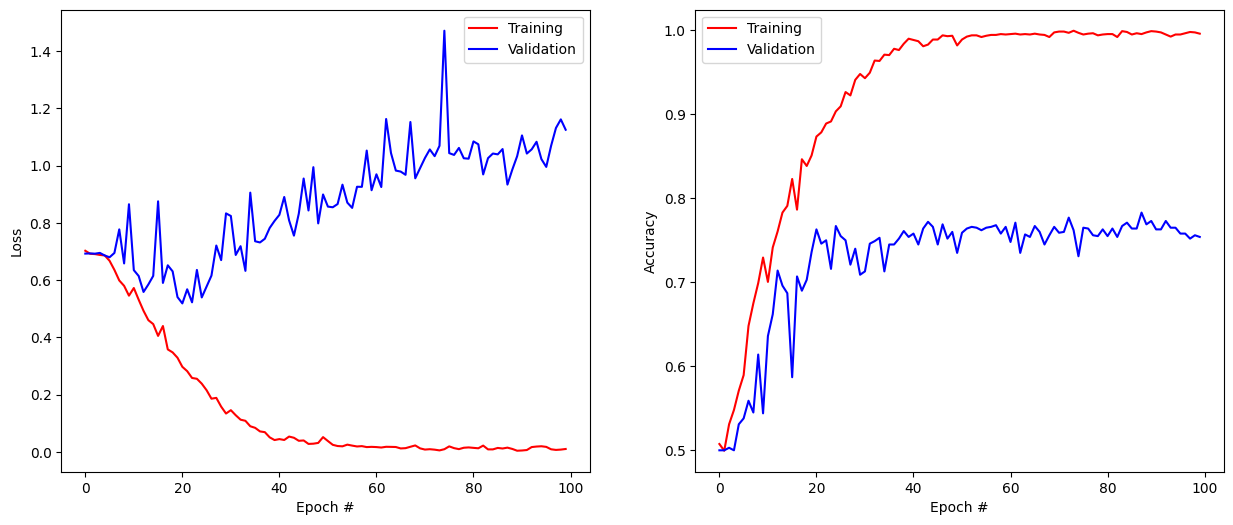

In [51]:
model = random_model(augmentation_preprocessing_pipeline)

history = tf.keras.callbacks.History()
cb_es = tf.keras.EarlyStopping(monitor='val_loss', patience=10)
model.fit(
      train_ds,
      epochs=100,
      validation_data=validation_ds,
      callbacks=[history,cb_es])

plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(history.history['loss'], '-r', label="Training")
plt.plot(history.history['val_loss'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['binary_accuracy'], '-r', label="Training")
plt.plot(history.history['val_binary_accuracy'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**A:** Data augmentation prevents overfitting, as the network never sees twice the same image. Learning is much slower, but it can bring the validation accuracy significantly higher (80% after 100 epochs).

## Transfer learning

Data augmentation helps randomly initialized to learn from small datasets, but the best solution is to start training with already good weights.

**Transfer learning** allows to reuse the weights of a CNN trained on a bigger dataset (e.g. ImageNet) to either extract features for a shallow classifier or to allow fine-tuning of all weights.

Keras provides a considerable number of pre-trained CNNs:

<https://keras.io/api/applications/>

In this exercise, we will use the Xception network for feature extraction, but feel free to experiment with other architectures. To download the weights and create the keras model, simply call:

```python
xception = tf.keras.applications.Xception(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        input_shape=(150, 150, 3), # Input shape
        include_top=False, # Only the convolutional layers, not the last fully-connected ones
    )
```

`include_top=False` removes the last fully-connected layers used to predict the ImageNet classes, as we only care about the binary cat/dog classification.

**Q:** Download Xception and print its summary. Make sense of the various layers (the paper might help: <http://arxiv.org/abs/1610.02357>). What is the size of the final tensor?



In [52]:
tf.keras.backend.clear_session()

xception = tf.keras.applications.Xception(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        input_shape=(150, 150, 3), # Input shape
        include_top=False, # Only the convolutional layers, not the last fully-connected ones
    )

print(xception.summary())

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 74, 74, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 74, 74, 32)     │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 74, 74, 32)     │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 72, 72, 64)     │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 72, 72, 64)     │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 72, 72, 64)     │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 72, 72, 128)    │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 72, 72, 128)    │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 72, 72, 128)    │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 72, 72, 128)    │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 72, 72, 128)    │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 36, 36, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 36, 36, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

None


Let's now use transfer learning using this network. The first thing to do is to freeze Xception to make sure that it does learn from the cats and dogs data:

```python
xception.trainable = False
```

We can then connect Xception to the inputs, making sure again that the network won't learn (in particular, the parameters of batch normalization are kept):

```python
inputs = tf.keras.Input(shape=(150, 150, 3))
x = xception(inputs, training=False)
```

We can now use the layer `x` and stack what we want on top of it. Instead of flattening the 5x5x2048 tensor, it is usually better to apply **average-pooling** (or mean-pooling) on each 5x5 feature map to obtain a vector with 2048 elements:

```python
x = tf.keras.layers.GlobalAveragePooling2D()(x)
```

**Q:** Perform a soft linear classification on this vector with 2048 elements to recognize cats from dogs (using non-augmented data). Do not hesitate to use some dropout and to boost your learning rate, there are only 2049 trainable parameters. Conclude.

In [53]:
def transfer_model():

    # Delete all previous models to free memory
    tf.keras.backend.clear_session()

    # Use Xception as a feature extractor
    xception = tf.keras.applications.Xception(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        input_shape=(img_height, img_width, 3), # Input shape
        include_top=False, # Only the convolutional layers, not the last fully-connected ones
    )  # Do not include the ImageNet classifier at the top.

    # Freeze the base model
    xception.trainable = False

    # Create new model on top
    inputs = tf.keras.Input(shape=(img_height, img_width, 3))

    # The base model contains batchnorm layers. We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base_model is running in inference mode here.
    x = xception(inputs, training=False)

    # GlobalAveragePooling2D applies average-pooling on each 5x5 feature map
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Regularize with dropout
    x = tf.keras.layers.Dropout(0.5)(x)

    # Output layer for binary classification
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    # Model
    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],
    )


    print(model.summary())

    return model

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

None
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 641ms/step - binary_accuracy: 0.8060 - loss: 0.4287 - val_binary_accuracy: 0.9510 - val_loss: 0.1230
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - binary_accuracy: 0.9539 - loss: 0.1209 - val_binary_accuracy: 0.9580 - val_loss: 0.0948
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - binary_accuracy: 0.9656 - loss: 0.0966 - val_binary_accuracy: 0.9560 - val_loss: 0.0905
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - binary_accuracy: 0.9682 - loss: 0.0820 - val_binary_accuracy: 0.9550 - val_loss: 0.0895
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - binary_accuracy: 0.9725 - loss: 0.0797 - val_binary_accuracy: 0.9590 - val_loss: 0.0884
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - binary_accuracy: 0.9705 - loss: 0.0775 - val_binary_accuracy: 0.9630 - val_loss: 0.0837
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - binary_accuracy: 0.9818 - loss: 0.0608 - val_binary_accuracy: 0.9610 - val_loss: 0.08

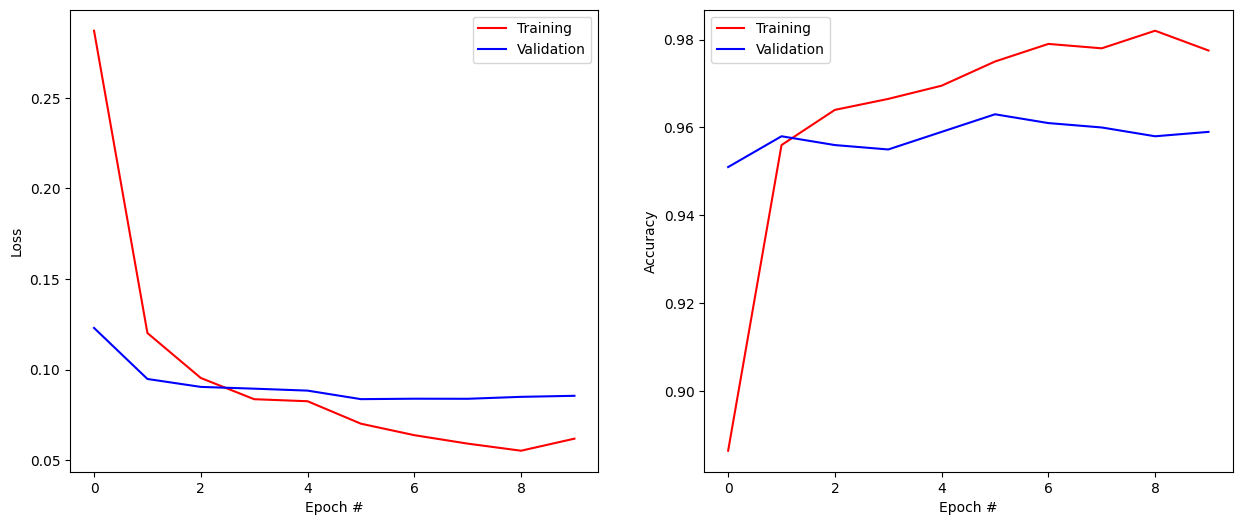

In [54]:
model = transfer_model()

history = tf.keras.callbacks.History()
model.fit(
      train_ds,
      epochs=10,
      validation_data=validation_ds,
      callbacks=[history])

plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(history.history['loss'], '-r', label="Training")
plt.plot(history.history['val_loss'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['binary_accuracy'], '-r', label="Training")
plt.plot(history.history['val_binary_accuracy'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**A:** Using feature extraction, we obtain very quickly a validation accuracy around 95% on the small unaugmented dataset, a performance out of reach of randomly initialized networks even with data augmentation. Conclusion: if you can use transfer learning, use it.